In [35]:
import os
import pickle
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from ai.ml.knn.inference import knn_inference
from ai.ml.knn.evaluation import evaluate

In [36]:
# cashrec_cashpaid
TENANT_ID = "77b67978-ae76-4480-ac96-066ea269541e"
TABLE_NAME = "accrec_accpay"
SERVICE = "gst_validation"

# Loading Model Selection


In [37]:
model_selection_timestamp = "2025-05-07-10-13-10"
model_selection_dir = f"/Users/amirhossein/Projects/bookiewand/ai/data/{SERVICE}/model_selection/{TENANT_ID}/{model_selection_timestamp}/{TABLE_NAME}"

In [38]:
with open(os.path.join(model_selection_dir, 'cv_results.json'), 'r') as handle:
    cv_results = json.load(handle)
with open(os.path.join(model_selection_dir, 'cv_best_minimal_config.json'), 'r') as handle:
    cv_best_minimal_config = json.load(handle)
with open(os.path.join(model_selection_dir, 'hyperparameters.json'), 'r') as handle:
    cv_hyperparameters = json.load(handle)
cv_df = pd.read_csv(os.path.join(model_selection_dir, 'df.csv'))

# Loading Train

In [39]:
train_timestamp = "2025-05-07-12-38-29"
train_checkpoints_dir = f"/Users/amirhossein/Projects/bookiewand/ai/data/{SERVICE}/checkpoints/{TENANT_ID}/{train_timestamp}/{TABLE_NAME}"

In [40]:
with open(os.path.join(train_checkpoints_dir, 'encoders.pkl'), 'rb') as handle:
    train_encoders = pickle.load(handle)
with open(os.path.join(train_checkpoints_dir, 'hyperparameters.json'), 'r') as handle:
    train_hyperparameters = json.load(handle)
with open(os.path.join(train_checkpoints_dir, 'model.pkl'), 'rb') as handle:
    knn_model = pickle.load(handle)
train_df = pd.read_csv(os.path.join(train_checkpoints_dir, 'train.csv'))

In [41]:
model_data = {
    "encoders": train_encoders,
    "hyperparameters": train_hyperparameters,
    "train_df": train_df,
    "knn_model": knn_model,
}

In [42]:
print("[*] target_variable: ", train_hyperparameters["target_variable"])
print("[*] numerical_features: ", train_hyperparameters["numerical_features"])
print("[*] categorical_features: ", train_hyperparameters["categorical_features"])
print("[*] n_neighbors: ", train_hyperparameters["n_neighbors"])
print("[*] weights: ", train_hyperparameters["weights"])
print("[*] X_train.shape: ", train_hyperparameters["X.shape"])
print("[*] y_train.shape: ", train_hyperparameters["y.shape"])

[*] target_variable:  tax_name
[*] numerical_features:  ['journal_line_tax_amount']
[*] categorical_features:  ['journal_line_description', 'source_type', 'invoice_contact_name']
[*] n_neighbors:  5
[*] weights:  uniform
[*] X_train.shape:  [37127, 19425]
[*] y_train.shape:  [37127]


# Loading Eval Data

In [43]:
raw_data_timestamp = "2025-05-07-12-38-29"
raw_data_dir = f"/Users/amirhossein/Projects/bookiewand/ai/data/{SERVICE}/raw/{raw_data_timestamp}/{TABLE_NAME}"
raw_df = pd.read_csv(os.path.join(raw_data_dir, f"{TENANT_ID}.csv"))

# Running Inference on Eval Data

In [44]:
# calling the knn inference over the raw df
response = knn_inference(tenant_id=TENANT_ID,
                         table_name=TABLE_NAME,
                         df=raw_df,
                         model_data=model_data)

[*] 2025-05-07 17:59:00 - INFO - Running KNN inference for tenant: 77b67978-ae76-4480-ac96-066ea269541e
[*] 2025-05-07 17:59:00 - INFO - Converted target variable to string and replaced specified missing values.
[*] 2025-05-07 17:59:00 - INFO - Found 0 missing values in target variable 'tax_name'.
[*] 2025-05-07 17:59:00 - INFO - Filled missing values in target variable 'tax_name' with 'NOT_APPLICABLE'.
[*] 2025-05-07 17:59:00 - INFO - Final unique values in tax_name: ['GST on Expenses' 'GST on Income' 'GST Free Income' 'GST Free Expenses'
 'BAS Excluded' 'GST on Capital' 'GST Free Exports']
[*] 2025-05-07 17:59:00 - INFO - Data shape after handling missing target values: (37128, 17)
[*] 2025-05-07 17:59:07 - INFO - Shape of feature matrix X: (37128, 19425)
[*] 2025-05-07 17:59:14 - INFO - Predictions made for 37128 samples.
[*] 2025-05-07 17:59:14 - INFO - Generating explanations for 37128 predictions.
[*] 2025-05-07 17:59:33 - INFO - Sample 10611 with REMOVED class during training GS

In [45]:
# computing the evaluation results dataframe
results_df = evaluate(response=response)

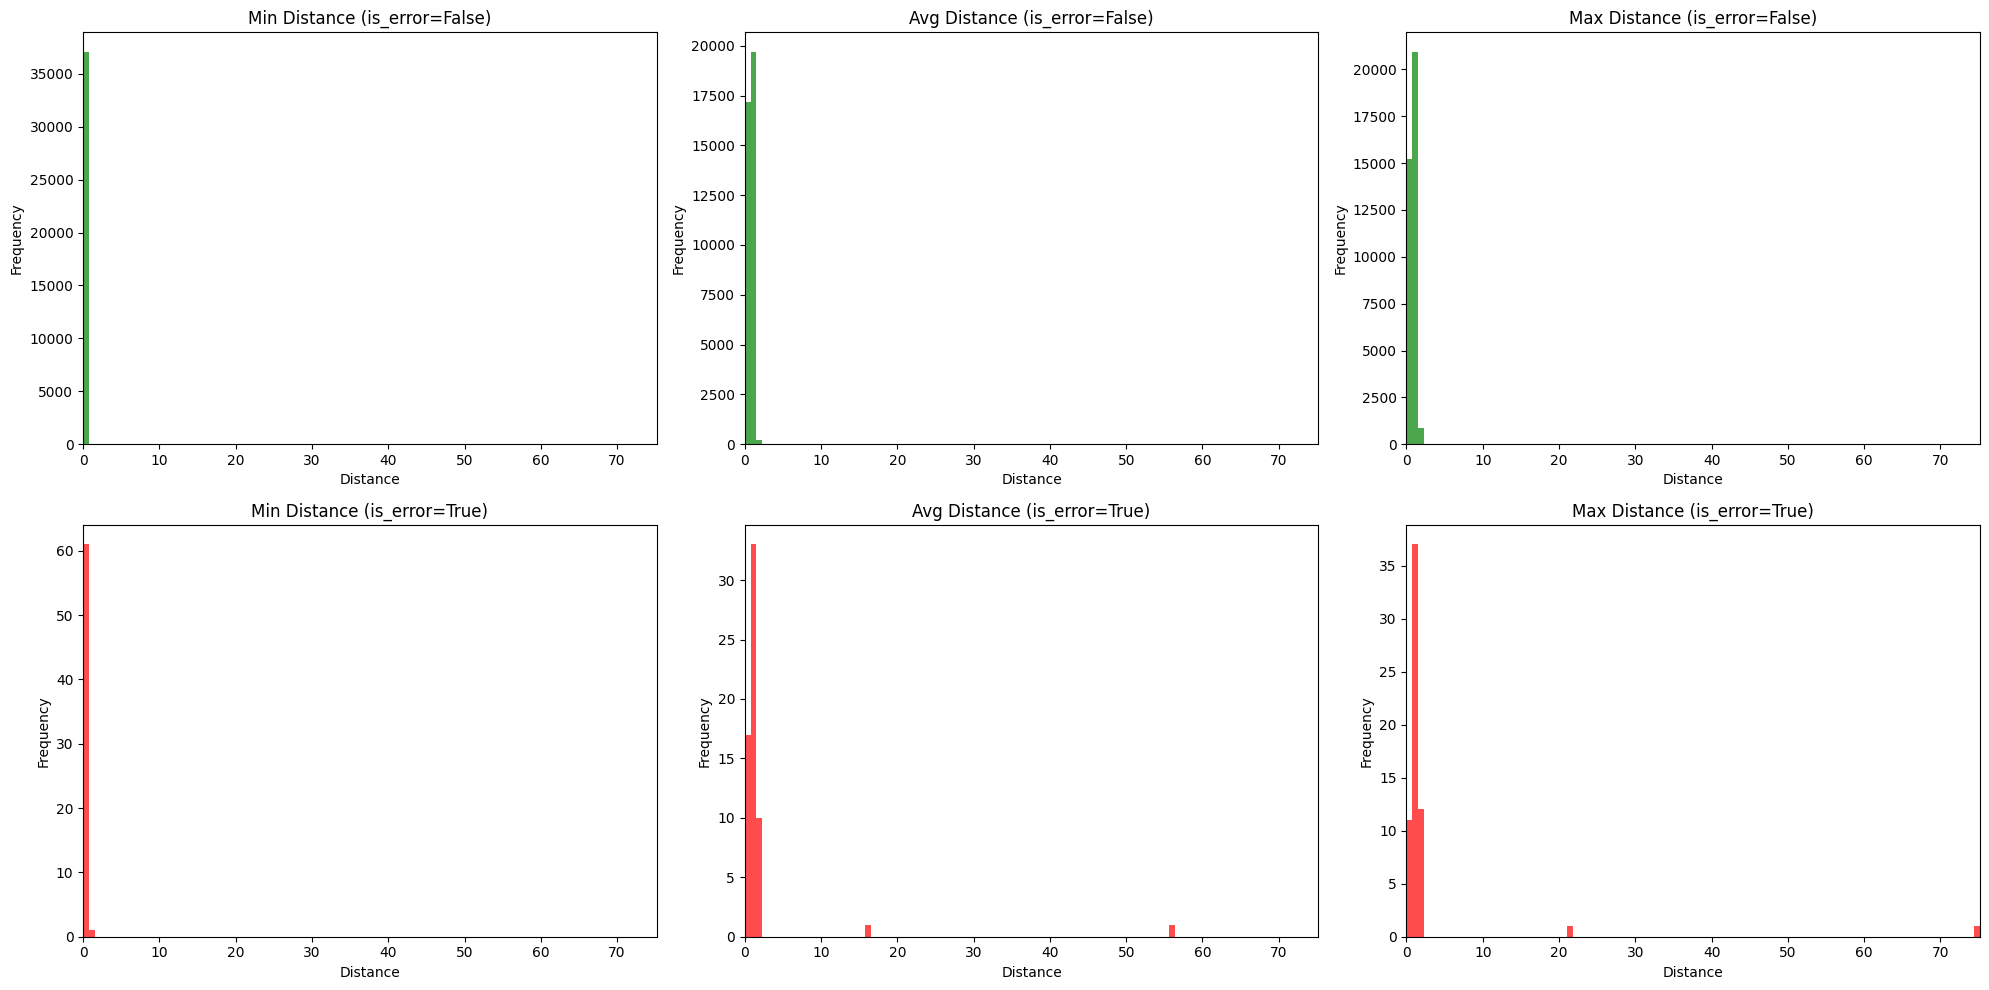

In [46]:
# plotting histogram of distances to neighbors for correct and wrong prediction

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

axes[0, 0].set_title('Min Distance (is_error=False)')
axes[0, 1].set_title('Avg Distance (is_error=False)')
axes[0, 2].set_title('Max Distance (is_error=False)')  # New title
axes[1, 0].set_title('Min Distance (is_error=True)')
axes[1, 1].set_title('Avg Distance (is_error=True)')
axes[1, 2].set_title('Max Distance (is_error=True)')  # New title

min_x = min(results_df['min_distance'].min(), results_df['avg_distance'].min(), results_df['max_distance'].min())
max_x = max(results_df['min_distance'].max(), results_df['avg_distance'].max(), results_df['max_distance'].max())

false_results = results_df[results_df['is_error'] == False]
true_results = results_df[results_df['is_error'] == True]

bins = np.linspace(min_x, max_x, 101)

axes[0, 0].hist(false_results['min_distance'], bins=bins, alpha=0.7, color='green')
axes[0, 1].hist(false_results['avg_distance'], bins=bins, alpha=0.7, color='green')
axes[0, 2].hist(false_results['max_distance'], bins=bins, alpha=0.7, color='green')  # New plot

axes[1, 0].hist(true_results['min_distance'], bins=bins, alpha=0.7, color='red')
axes[1, 1].hist(true_results['avg_distance'], bins=bins, alpha=0.7, color='red')
axes[1, 2].hist(true_results['max_distance'], bins=bins, alpha=0.7, color='red')  # New plot

for ax in axes.flatten():
    ax.set_xlim(min_x, max_x)
    ax.set_xlabel('Distance')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [47]:
# computing the accuracy
accuracy = 1 - len(results_df[results_df["is_error"]]) / len(results_df)
print("[*] Evaluation accuracy:", accuracy)

[*] Evaluation accuracy: 0.9983301012712777


In [48]:
# Confusion matrix
cm = confusion_matrix(
    y_true=results_df['ground_truth'],
    y_pred=results_df['prediction']
)

In [49]:
# Check the shape of the confusion matrix
print(f"Confusion matrix shape: {cm.shape}")

# Calculate precision, recall, and accuracy for each class
unique_classes = np.unique(results_df['ground_truth'])
n_classes = len(results_df['ground_truth'].unique())
metrics_data = []

total_samples = cm.sum()
class_samples = np.sum(cm, axis=1)  # Sum of rows gives total samples per class

for i in range(n_classes):
    # get the ground-truth class label
    gt_label = unique_classes[i]
    num_gt_labels_in_raw_df = len(raw_df[raw_df['tax_name'] == gt_label])
    num_gt_labels_in_train_df = len(train_df[train_df['tax_name'] == gt_label])

    # True positives: diagonal element
    tp = cm[i, i]

    # False positives: sum of column i - true positives
    fp = cm[:, i].sum() - tp

    # False negatives: sum of row i - true positives
    fn = cm[i, :].sum() - tp

    # True negatives: sum of all values - (tp + fp + fn)
    tn = total_samples - (tp + fp + fn)

    # Number of samples in this class
    samples = class_samples[i]

    # Percentage of samples
    samples_percentage = (samples / total_samples) * 100

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / total_samples


    metrics_data.append({
        'class': gt_label,
        'num_samples_in_eval': num_gt_labels_in_raw_df,
        'pct_in_eval (%)': samples_percentage,
        'num_samples_in_train': num_gt_labels_in_train_df,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    })

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics_data)

# Calculate weighted macro averages
weighted_precision = np.average(metrics_df['precision'], weights=metrics_df['num_samples_in_eval'])
weighted_recall = np.average(metrics_df['recall'], weights=metrics_df['num_samples_in_eval'])
weighted_accuracy = np.average(metrics_df['accuracy'], weights=metrics_df['num_samples_in_eval'])


# Calculate simple macro averages
macro_precision = metrics_df['precision'].mean()
macro_recall = metrics_df['recall'].mean()
macro_accuracy = metrics_df['accuracy'].mean()

# Add macro and weighted averages to the DataFrame
summary_metrics_df = pd.concat([
    pd.DataFrame([{
        'class': 'Macro Avg',
        'num_samples_in_eval': total_samples,
        'pct_in_eval (%)': metrics_df['pct_in_eval (%)'].sum(),
        'num_samples_in_train': metrics_df['num_samples_in_train'].sum(),
        'precision': macro_precision,
        'recall': macro_recall,
        'accuracy': macro_accuracy
    }]),
    pd.DataFrame([{
        'class': 'Weighted Avg',
        'num_samples_in_eval': total_samples,
        'pct_in_eval (%)': metrics_df['pct_in_eval (%)'].sum(),
        'num_samples_in_train': metrics_df['num_samples_in_train'].sum(),
        'precision': weighted_precision,
        'recall': weighted_recall,
        'accuracy': weighted_accuracy
    }])
], ignore_index=True)

# Calculate overall accuracy (global accuracy)
overall_accuracy = (np.trace(cm) / total_samples).item()

Confusion matrix shape: (7, 7)


In [50]:
overall_accuracy

0.9983301012712777

In [51]:
metrics_df

,class,num_samples_in_eval,pct_in_eval (%),num_samples_in_train,TP,FP,TN,FN,precision,recall,accuracy
0,BAS Excluded,126,0.339367,126,119,23,36979,7,0.838028,0.944444,0.999192
1,GST Free Expenses,51,0.137363,51,42,4,37073,9,0.913043,0.823529,0.999650
2,GST Free Exports,1,0.002693,0,0,0,37127,1,0.000000,0.000000,0.999973
3,GST Free Income,109,0.293579,109,98,6,37013,11,0.942308,0.899083,0.999542
4,GST on Capital,12,0.032321,12,0,0,37116,12,0.000000,0.000000,0.999677
5,GST on Expenses,13905,37.451519,13905,13888,16,23207,17,0.998849,0.998777,0.999111
6,GST on Income,22924,61.743159,22924,22919,13,14191,5,0.999433,0.999782,0.999515


In [52]:
summary_metrics_df

,class,num_samples_in_eval,pct_in_eval (%),num_samples_in_train,precision,recall,accuracy
0,Macro Avg,37128,100.0,37127,0.670237,0.666517,0.999523
1,Weighted Avg,37128,100.0,37127,0.998030,0.998330,0.999363


In [53]:
error_groups = results_df[results_df['is_error'] == True].groupby(['prediction', 'ground_truth'])

# 3. Calculate error count and validate class_frequency
error_analysis = []
for (pred, truth), group in error_groups:
    # Check if class_frequency has more than one unique value
    unique_frequencies = group['class_frequency'].unique()
    if len(unique_frequencies) > 1:
        raise ValueError(f"Multiple class_frequency values found for prediction={pred}, ground_truth={truth}")

    # Create a record for this error group
    error_analysis.append({
        'prediction': pred,
        'ground_truth': truth,
        'error_count': len(group),
        'class_frequency': unique_frequencies[0]
    })

# Convert to DataFrame and sort by error count
error_df = pd.DataFrame(error_analysis)
error_df = error_df.sort_values('error_count', ascending=False).reset_index(drop=True)

In [54]:
error_df

,prediction,ground_truth,error_count,class_frequency
0,BAS Excluded,GST on Expenses,10,37.45
1,GST on Expenses,GST on Capital,10,0.03
2,BAS Excluded,GST Free Expenses,7,0.14
3,BAS Excluded,GST Free Income,6,0.29
4,GST on Income,GST on Expenses,6,37.45
5,GST Free Income,GST on Income,5,61.74
6,GST on Income,GST Free Income,5,0.29
7,GST on Expenses,BAS Excluded,4,0.34
8,GST Free Expenses,BAS Excluded,3,0.34
9,GST on Expenses,GST Free Expenses,2,0.14
